# Unsupervised Learning

In this section we begin exploring some unsupervised learning concepts.

We have two main goals from this section:
1. Feature Importance Determination
2. Identifiying Similiar Player Profiles of athletes with and without NIL Evaluations

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Since our pipeline is not up and running yet, let's just import the traintestsplit function
from python_scripts.traintestsplit import custom_train_test_split

In [3]:
# Read in the cleaned CSV
df = pd.read_csv("cleaned_files/basketball_clean_unsupervised.csv")
X_train = df.set_index('NAME')

## Feature Importance Determination

The outputs of this feature importance determination will be crucial in plotting and visualizing things from the KMeans Effort Below!

Since our goal is to reduce our problem down for visualization purposes we are going to explore options in which the number of components is either 2 or 3 although a further analysis regarding the importance of features should also be performed.

It is sometimes good for very large, high-dimensional datasets to use PCA and then apply t-SNE/UMAP after!

In [4]:
def dimReductionPrep(X_train):
    """
        :: Input(s) ::
            X_train - the training feature dataset
        :: Output(s) ::
            X_train_Reduced - the training feature dataset with only numeric columns included
        :: Explaination of Function ::
            Lots of unsupervised functions require that data be mean centered and normalized. We cannot mean center and normalize non-numerica data so this function helps
            take the output from "traintestsplit" and reduce the columns down to only those with numeric features
    """

    cols2Keep = ['AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN',
                 'WEIGHT_LBS', 'COLLDIST_MI', 'TOT_FOL', 'EXP_MONTHS',
                 'ClassificationCode', 'REV_MEN', 'EXP_MEN']
    
    X_train_Reduced = X_train[cols2Keep]

    return X_train_Reduced

#### Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is a technique that looks to retain as much information as possible from our original data space while reducing the overall number of features. In this way PCA can help us perform "feature selection" and "feature extraction".

"Feature Selection" is the is the act of finding a subset of features from the original feature list that are the most relevant or useful. In the case of unsupervised learning we could look to see what features are most correlated with each other in order to reduce any potential redundancies within the feature space as well as look to see which handful of our original features (2-3) most closely associated with the dimensions that some dimensionality reduction techniques that PCA outputs (explained in more detail below).

"Feature Extraction" on the otherhand is the act of extracting/constructing new features from the original features. We refer to these features as "latent features" as they do not explicitly exist within the dataset but these features could be thought of as overarching motifs that can summarize a collection of the original features from our dataset (explained in more detail below).

##### PCA Scree Plots

Scree plots are a very useful tool in the world of building PCA models. These plots show the eigenvalues of each principal component that the PCA model has learned and can help the user understand how much variation can be retained by taking a subset, k, principal components from the original dataset p (where k < p). User's should look at the elbow of Scree plots to help get an intuitive understanding of just how many principal components should be retained. It can also be useful to look at how much cumulative variance from the original dataset is remembered by taking the top k principal components.

In the function below, we look to generate a Scree plot that communicates these exact ideas.

In [5]:
def custom_PCA_Scree(X_train_Reduced, threshold=0.8):
    """
        :: Input(s) ::
            X_train_Reduced - training data with only numeric columns (from dimReductionPrep)
            threshold - the amount of explained variance that the user would like to be captured by the minimum number of pricipal components (default is 0.8)
        :: Output(s) ::
            None
        :: Explaination of Function ::
        This fucntion performs Principal Components Analysis (PCA)
        The goal here is two fold:
            1. Generate a Scree Plot that incorporates an explained varaince ratio
            2. Help the user determine the minumum number of components in order to consider utilizing PCA
    """

    # Normalize the data prior to performing PCA!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train_Reduced)
    pca = PCA()
    X_pca = pca.fit_transform(X_train_Norm)

    # Since the n_comp is dynamic, we need a dynamic way to show the PC's
    PCs = []
    for i in range(len(X_train_Reduced.columns)):
        PCs.append('PC{}'.format(i+1))

    # Generate the Cumulative Sum of Explained Variance
    dfCumul = pd.DataFrame({'perc_explained_var_ratio': pca.explained_variance_ratio_,
                            'PC': PCs})
    dfCumul['cumulative_variance'] = dfCumul['perc_explained_var_ratio'].cumsum()
    n_components_thresh = np.argmax(dfCumul['cumulative_variance'] >= threshold) + 1

    # dfScree = pd.DataFrame({'explained_var': np.sqrt(pca.explained_variance_),
    #                         'PC': PCs})

    # Generate the Scree Plot
    plt.figure(figsize=(8,6))
    plt.plot(dfCumul['PC'],
             dfCumul['perc_explained_var_ratio'],
             color='b',
             marker='o',
             linestyle='--',
             label='Variance Explained by PC')
    plt.xlabel('Principal Component (PC)')
    plt.ylabel('Percentage of Explained Variance')
    plt.title('PCA Scree Plot')
    
    plt.plot(dfCumul['PC'],
             dfCumul['cumulative_variance'],
             color='k',
             label="Cumulative Variance Explained")
    
    plt.axvline(dfCumul['PC'][n_components_thresh - 1],
                color='red',
                label="{:.0f}% Threshold".format(threshold*100))
    
    plt.legend()
    plt.show()

    return None

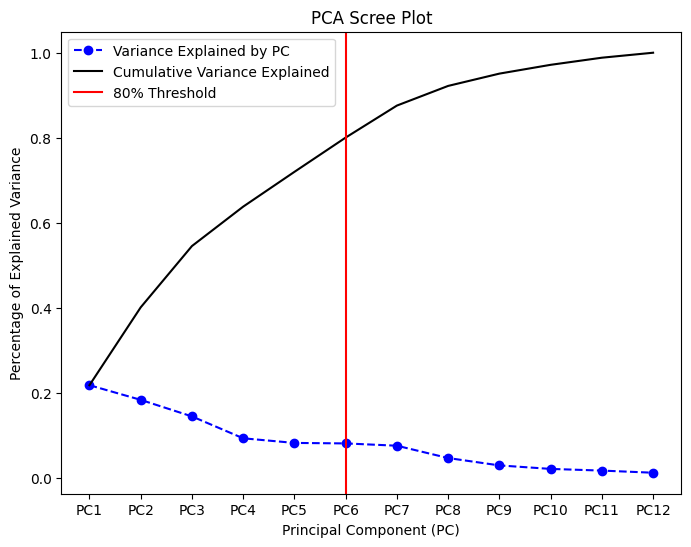

In [6]:
custom_PCA_Scree(dimReductionPrep(X_train))

From this scree plot we can see that in order to retain roughly 80% of the original data's variance, we would need to keep the top 6 principal components. We can also see that there isn't really a natural "elbow" in this plot on top of the fact that the number of principal components is quite high in order to retain the data's information. This might lead us to believe that the data is non-linear in nature that something like PCA alone might not be a good indicator for dimensionality reduction.

However, let's go ahead in the next section making a biplot and let's utilize 3 principal components (which will assist in our biplot visualization). 3 principal components appears to retain roughly 50% of the original data's information.

##### PCA Biplots

Biplots are a fantastic tool to visualize PCA in either 2 or 3 dimensions while allowing us to overlay the original features in the space. The motivation behind biplots really comes into play when we look to address our two main goals with PCA: feature selection and feature extraction.

For feature selection we look to see which features align most closely with each principal component. In this way we would take 1 original feature for each principal component and discard the rest. For feature extraction we could instead look to see which feature(s) are associated with each principal component in order to try and get a latent label for each principal component. For example: If a PC1 was most closely associated with 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG' then we might be inclined to say that PC1 is "Social Media Presence" or something to that effect.

In [13]:
# Add 'n_comps' input to function
# Need to output the top feature associated with each PC (feature selection)
# Need to output the top n_comps features associated with each PC (feature extraction)

def custom_BiPlot(X_train_Reduced, dimensions=2):
    """
        :: Input(s) ::
            X_train_Reduced - training data with only numeric columns (from dimReductionPrep)
            dimensions - The number of dimensions that we can plot in (must be either 2 or 3)
            n_comps - The number of components that you would like included in the feature extraction piece of this function
        :: Output(s) ::
            "Feature Selection" -- Names the components with the best cosine similiarity to each of the principal components
            "Feature Extraction" -- Names the top n (n_comps) associated with each principal component
        :: Explaination of Function ::
            This function creates a biplot from the PCA solution in either 2d or 3d.
            The biplot shows the two (or three) principal components with the biggest eigenvalues (PC's that explain the most variance in the data)
            and plots the data as well as the original features as vectors in this space.

            It also returns the features from the original feature space that most closely align (via cosine similiarity) to each principal component (feature selection)
            as well as the group of features (indicated by n_comps) that most closely aligns with each principal component which could in turn be used by the user to
            estimate a sort of "latent feature name" for each PC (feature extraction)
    """
    # Error Handling
    if (dimensions < 2) or (dimensions > 3):
        print("Dimensions must be either 2 or 3! Try again!")
        return None
    
    # Normalize the data prior to performing PCA!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train_Reduced)
    pca = PCA(n_components=dimensions)
    X_pca = pca.fit_transform(X_train_Norm)

    # Generate the Plot
    plt.figure(figsize=(10, 12))
    maxdim = len(X_train_Reduced.columns)

    if dimensions == 2:
        coeff = np.transpose(pca.components_[0:2, :])

        xs = X_pca[:,0]
        ys = X_pca[:,1]

        n = min(coeff.shape[0], maxdim)
        scalex = 2.0 / (xs.max() - xs.min())
        scaley = 2.0 / (ys.max() - ys.min())
        text_scale_factor = 1.5

        plt.scatter(xs * scalex, ys * scaley, s=5)

        for i in range(n):
            plt.arrow(0,0,coeff[i,0],coeff[i,1],color='red',alpha=0.5)
            plt.text(
                coeff[i,0] * text_scale_factor,
                coeff[i,1] * text_scale_factor,
                X_train_Reduced.columns[i],
                color='g',
                ha='center',
                va='center'
            )
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.title('PCA Biplot')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid()
        plt.tight_layout()
        plt.show()
    else:
        coeff = np.transpose(pca.components_[0:3, :])

        xs = X_pca[:,0]
        ys = X_pca[:,1]
        zs = X_pca[:,2]

        n = min(coeff.shape[0], maxdim)
        scalex = 2.0 / (xs.max() - xs.min())
        scaley = 2.0 / (ys.max() - ys.min())
        scalez = 2.0 / (zs.max() - zs.min())
        text_scale_factor = 1.5

        ax = plt.axes(projection='3d')
        ax.grid()
        scatter = ax.scatter(xs * scalex,
                             ys * scaley,
                             zs * scalez,
                             s=5)
        
        for i in range(n):
            # ax.arrow3D(0,0,0,
            #            coeff[i,0], coeff[i,1], coeff[i,2],
            #            mutation_scale=20,
            #            arrowstyle="-|>",
            #            fc='red')
            ax.quiver(0, 0, 0,
                      coeff[i,0], coeff[i,1], coeff[i,2],
                      color='red')
            ax.text(
                coeff[i,0] * text_scale_factor,
                coeff[i,1] * text_scale_factor,
                coeff[i,2] * text_scale_factor,
                X_train_Reduced.columns[i],
                color='g',
                ha='center',
                va='center'
            )
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        ax.set_title("PCA Biplot")
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        
        plt.show()
    return None

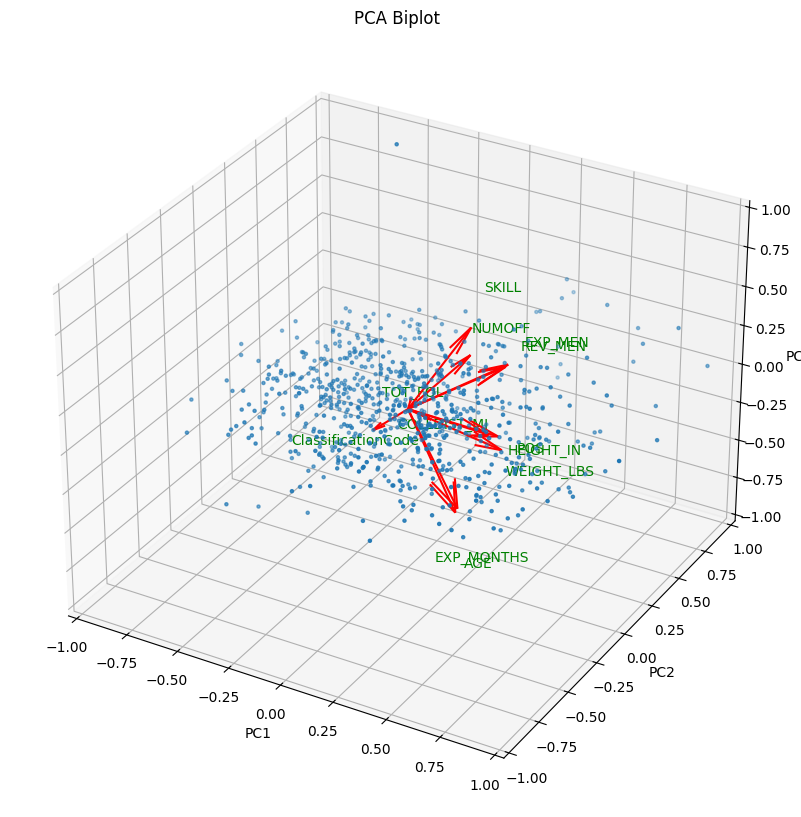

In [16]:
custom_BiPlot(dimReductionPrep(X_train), dimensions=3)

We can clearly see that in 2 or 3 dimensions there are a couple of features in the original feature space that correlate well with each axis (feature selection) and if we print out the top 'n_comps' features associated with each axis we can get an understanding of the latent feature name that a principal component might take!

#### Multidimensional Scaling (MDS)

- Distance preserving low-dimensional projection
- Locally influenced
- If clusters are far apart in the OG data, then they will be far apart in the MDS projection
- weights can be introduced to handle missing data in MDS! We have lots of missing data in this project...

In [15]:
def custom_MDS(X_train_Reduced):
    """
        :: Input(s) ::
            X_train_Reduced - training data with only numeric columns
            y_train - the labelled training data which assigns clusters... Could make this dynamic based on whether or not y_train exists?
            n_comp - the number of components that will be graphed for the scatterplot
        :: Output(s) ::
            None
        :: Explaination of Function ::
            This function helps plot the Multidimensional Scaling (MDS) feature space to help us understand
            how data could be preserved using MDS. MDS is a method that helps to retain local distance whereas PCA performs
            global distances.
    """
    # Normalize the data prior to performing MDS!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train_Reduced)
    mds = MDS(normalized_stress='auto')
    X_mds = mds.fit_transform(X_train_Norm)

    # Bin the output values to help with clusters
    # https://taxfoundation.org/data/all/federal/2023-tax-brackets/
    # bins = [0, 11000, 44725, 95375, 182100, 231250, 578125, np.inf]
    # labels = ['10% Tax Bracket', '12% Tax Bracket', '22% Tax Bracket',
    #           '24% Tax Bracket','32% Tax Bracket', '35% Tax Bracket', '37% Tax Bracket']
    # y_train_cat = pd.cut(y_train, bins=bins, labels=labels)

    plt.figure(figsize=(8,6))
    plt.scatter(X_mds[:,0],
                X_mds[:,1])
    
    # mplcursors.cursor(scatter, hover=True).connect(
    #     "add", lambda sel: sel.annotation.set_text(X_mds.index[sel.target.index]))
    
    plt.title('MDS Scatter Plot w/ Categorical Clusters')
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")

    for i, txt in enumerate(df.index):
        if i < len(X_mds):  # Check if i is within bounds
            plt.annotate(txt, (X_mds[:,0][i]+0.3, X_mds[:,1][i]))
    plt.show()

    return None

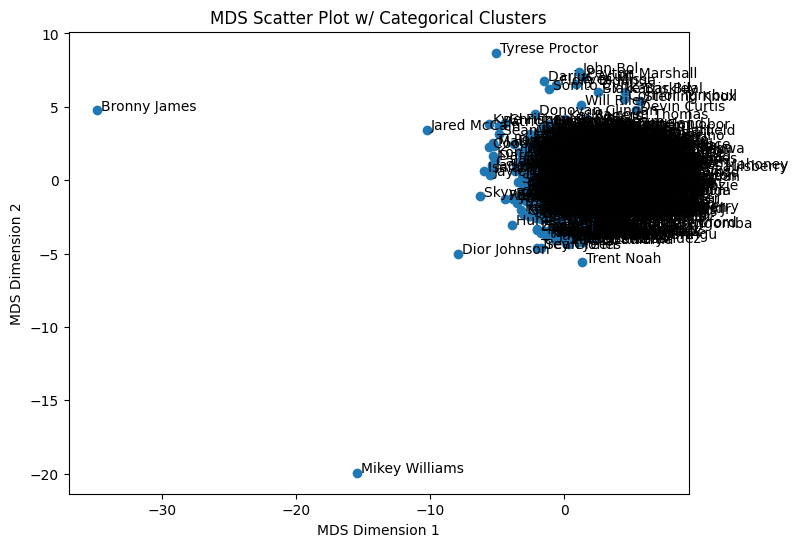

In [16]:
custom_MDS(dimReductionPrep(X_train))

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

- Finds a low-dim output
    - Preserves similiaries in high-dim data
    - It is focused on preserving LOCAL DISTANCES between neighbors, not so much global structure
    - Perplexity is the key parameter
        - Experiment with multiple values here!
    - Can give different output everytime it runs!

In [ ]:
# ==== tSNE =====
from sklearn.manifold import TSNE
# tsne = TSNE(random_state=0)
# X_tsne = tsne.fit_transform(X_norm)

# plot(X_tsne, output, [NAMES_OF_CLUSTERS])
# ===============

#### Uniform Manifold Approximation & Projection (UMAP)

- Similiar to t-SNE --> Preserves local neighborhood structure
- But it also preserves some global structure too!
- It is a useful technique for plotting AS WELL AS clustering whereas t-SNE should not be used in clustering...

## Similiar Player Profiles

Notes regarding KMeans clustering:
- Different intializations can result in different solutions. Performing multiple runs is a good idea.
    - Be careful about where you start
    - Could place the first one randomly and the next one could be as far away as possible
- Centroid is typically the mean of the points in the cluster.
    - This works only when the values are continuous in nature. K-Medoid can be used if non-continuous columns are used.
- "Closeness" can take the form of Euclidean Distance, Cosine Similiarity, Correlation, etc

KMeans works well on simple clusters that are similiar in size, well seperated, and globular. Complex shapes... not so much...

##### Visualization Tips

When it comes to plotting this data it will be difficult to use normal ol KMeans because our data has lots of columns.
- PCA would work to reduce the data down to maybe two principal components
- t-SNE would also work to reduce the visualization down to something that is more interpretable

In [22]:
def custom_KMeans_Scree(X_train, max_clusters=8, RANDOM_STATE=0):
    """
        :: Input(s) ::
            X_train - training data
        :: Output(s) ::
            A Scree Plot
        :: Explaination of Function ::
            This function can be used to help the user determine the appropriate number of clusters to choose for this problem
    """

    # Remember that X_train does not contain any NIL information, that is perfectly okay because we are interested in all athletes
    # regardless of their NIL evaluation

    # We may want to normalize the features we have in some way, shape, or form...
    X_normalized = StandardScaler().fit_transform(X_train)

    # Elbow Plot Setup
    upperBound = max_clusters + 1
    scores = []
    centers = list(range(1,upperBound))
    for cluster in range(1,upperBound):
        kmeans = KMeans(n_clusters=cluster,
                        random_state=RANDOM_STATE)
        kmeans.fit(X_normalized)
        scores.append(np.abs(kmeans.score(X_normalized)))
    
    plt.figure(figsize=(8,6))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.xlabel('# of Clusters')
    plt.ylabel('Sum of Square Errors (SSE)')
    plt.title('SSE vs # of Clusters')

    return None

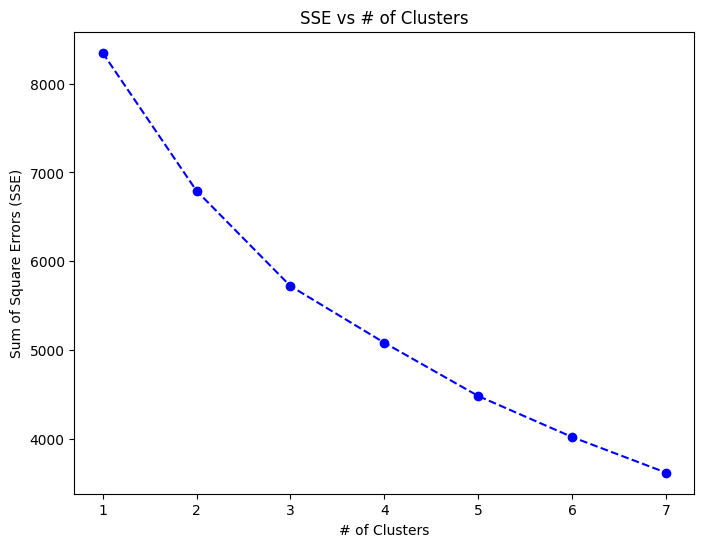

In [23]:
custom_KMeans_Scree(dimReductionPrep(X_train), max_clusters=7)

In [32]:
def custom_KMeans(X_train, num_clusters=3, RANDOM_STATE=0):
    """
        :: Input(s) ::
            X_train - Can only have 2 or 3 features for plotting purposes!
            num_clusters - the number of clusters that KMeans will divide the data up into
            RANDOM_STATE - the random state for this function (for repeatability)
        :: Output(s) ::
            A KMeans cluster plot
        :: Explaination of Function ::
            This function is supposed to be used ~after~ custom_KMeans_Scree after the user has determined the appropriate number of clusters to plot
    """
    # We may want to normalize the features we have in some way, shape, or form...
    X_normalized = StandardScaler().fit_transform(X_train)

    kmeans = KMeans(n_clusters=num_clusters,
                    random_state=RANDOM_STATE)
    model = kmeans.fit(X_normalized)
    labels = model.predict(X_normalized)

    plt.figure(figsize=(8,6))

    if X_normalized.shape[-1] == 3:
        ax = plt.axes(projection='3d')
        ax.grid()
        scatter = ax.scatter(X_normalized[:,0],
                             X_normalized[:,1],
                             X_normalized[:,2],
                             c=labels,
                             label=labels)
        ax.set_title("KMeans Cluster Plot")
        ax.set_xlabel('{}'.format(X_train.columns[0]), labelpad=5)
        ax.set_ylabel('{}'.format(X_train.columns[1]), labelpad=5)
        ax.set_zlabel('{}'.format(X_train.columns[2]), labelpad=5)
    elif X_normalized.shape[-1] == 2:
        scatter = plt.scatter(X_normalized[:,0],
                              X_normalized[:,1],
                              c=labels,
                              label=labels)
        plt.title('KMeans Cluster Plot')
        plt.xlabel('{}'.format(X_train.columns[0]))
        plt.xlabel('{}'.format(X_train.columns[1]))
    else:
        print("X_train has too many features... can only plot data with 2 or 3 features!")
        return None
    
    legend_entries = []
    for cluster_label in range(num_clusters):
        legend_entry = f'Cluster {cluster_label}'
        legend_entries.append(legend_entry)
    
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_entries, title="Cluster")

    # Plot the names of some of the players in a cluster!
    # dimReductionPrep(X_train)[['COLLDIST_MI', 'SKILL']]
    for i, label in enumerate(labels):
        if label == 2:
            plt.annotate(df.index[i], (X_normalized[:,0][i]+0.3, X_normalized[:,1][i]))
    
    plt.show()

    return None

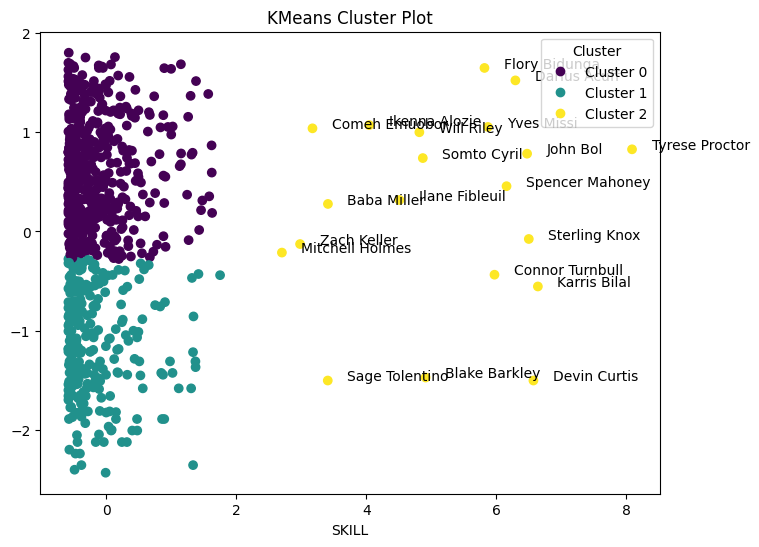

In [33]:
custom_KMeans(dimReductionPrep(X_train)[['COLLDIST_MI', 'SKILL']], num_clusters=3)

I would then like to implement:
1. Some kind of hierarchical clustering method (cluster.Agglo...) which could output a dendrogram
2. DBSCAN which could output a really nice plot that can handle some complicated data